<a href="https://colab.research.google.com/github/ComputationalScienceLaboratory/control-pinn/blob/main/ControlPINN_Analytical_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physics-informed neural networks for PDE-constrained optimization and control
## Jostein Barry-Straume, Arash Sarshar, Andrey A. Popov, Adrian Sandu
## [Computational Science Lab](https://csl.cs.vt.edu/), Department of Computer Science, Virginia Tech

> Paper and Code can be found here: https://github.com/ComputationalScienceLaboratory/control-pinn

> This Google Colab notebook contains the code for training a Control PINN model on an analytical open-loop optimal control problem

In [1]:
'''
Import the necessary libraries
'''
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Supress INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

## Create Datasets for Optimal Solutions

In [2]:
def y_star_fun(t):
  return (2 * math.exp(3*t) + math.exp(3)) / (math.exp(3*t/2) * (2 + math.exp(3)))
def u_star_fun(t):
  return (2 * (math.exp(3*t) - math.exp(3))) / (math.exp(3*t/2) * (2 + math.exp(3)))
def lambda_star_fun(t):
  return -1 * u_star_fun(t)
def g_fun(t):
  return (y_star_fun(t) ** 2) + (0.5 * (u_star_fun(t) ** 2))
def f_fun(t):
  return (0.5 * y_star_fun(t)) + u_star_fun(t)

timespan = np.arange(0.0, 1.001, 0.001)
y_star = np.asarray([y_star_fun(t) for t in timespan])
u_star = np.asarray([u_star_fun(t) for t in timespan])
lambda_star = np.asarray([lambda_star_fun(t) for t in timespan])
g_star = np.asarray([g_fun(t) for t in timespan])
f_star = np.asarray([f_fun(t) for t in timespan])
print(y_star.shape, u_star.shape, lambda_star.shape, g_star.shape, f_star.shape)

(1001,) (1001,) (1001,) (1001,) (1001,)


## Plot exact solutions and create datasets

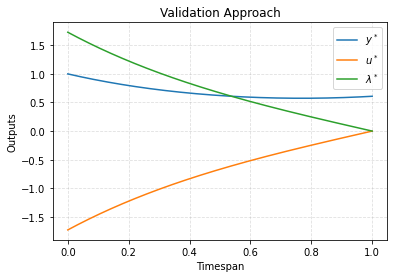

In [3]:
'''
This is just a sanity check to make sure that the exact solutions of
the dynamical system, the controller, and the system's resistance
has been calculated properly 
'''
plt.plot(timespan, y_star, label='$y^*$')
plt.plot(timespan, u_star, label='$u^*$')
plt.plot(timespan, lambda_star, label='$\lambda^*$')
plt.title('Validation Approach')
plt.xlabel('Timespan')
plt.ylabel('Outputs')
plt.legend()
plt.grid(alpha=.4, linestyle='--')

In [4]:
'''
y_star, u_star, and lambda_star represent the exact solutions
to the analytical problem.
'''
t_train        = timespan
output_y_exact = y_star
output_u_exact = u_star
output_l_exact = lambda_star
out_train      = (np.vstack([y_star, u_star, lambda_star])).T
print(t_train.shape, out_train.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((t_train.reshape(-1,1), out_train.reshape(-1,3))).shuffle(buffer_size=1000)
batchSize = 550
train_dataset = train_dataset.batch(batchSize)

(1001,) (1001, 3)


## Decouple w/ Sparse Data

In [5]:
def y_star_fun(t):
  return (2 * math.exp(3*t) + math.exp(3)) / (math.exp(3*t/2) * (2 + math.exp(3)))
def u_star_fun(t):
  return (2 * (math.exp(3*t) - math.exp(3))) / (math.exp(3*t/2) * (2 + math.exp(3)))
def lambda_star_fun(t):
  return -1 * u_star_fun(t)
def g_fun(t):
  return (y_star_fun(t) ** 2) + (0.5 * (u_star_fun(t) ** 2))
def f_fun(t):
  return (0.5 * y_star_fun(t)) + u_star_fun(t)

In [6]:
timespanSparse = np.arange(0.0, 1.001, 0.1)
y_sparse = np.asarray([y_star_fun(t) for t in timespanSparse])
u_sparse = np.asarray([u_star_fun(t) for t in timespanSparse])
lambda_sparse = np.asarray([lambda_star_fun(t) for t in timespanSparse])
g_sparse = np.asarray([g_fun(t) for t in timespanSparse])
f_sparse = np.asarray([f_fun(t) for t in timespanSparse])
print(y_sparse.shape, u_sparse.shape, lambda_sparse.shape, g_sparse.shape, f_sparse.shape)

(11,) (11,) (11,) (11,) (11,)


In [7]:
t_train        = timespanSparse
output_y_exact = y_sparse
output_u_exact = u_sparse
output_l_exact = lambda_sparse
out_train      = (np.vstack([y_sparse, lambda_sparse, u_sparse])).T
print(t_train.shape, out_train.shape)

train_dataset = tf.data.Dataset.from_tensor_slices((t_train.reshape(-1,1), out_train.reshape(-1,3))).shuffle(buffer_size=1000)
batchSize = 24
train_dataset = train_dataset.batch(batchSize)

(11,) (11, 3)


## PINN Model Class

In [8]:
class PINNModel(keras.Model):
  def __init__(self, num_unit=100, debug=0):
    '''
    Initialize the model object.
    :param num_unit: Number of nodes per layer, default is 100
    :param debug: If zero, prints to console the values of
                  systemPushBack, systemControl, and pdeLoss. Default is zero
    '''
    super(PINNModel, self).__init__()

    self.num_unit = num_unit
    self.debug = debug
    self.u              = None
    self.l              = None
    self.y              = None
    self.out            = None
    self.f              = None
    self.g              = None
    self.dydxx          = None
    self.dydt           = None
    self.dldt           = None
    self.dfdy           = None
    self.dfdu           = None
    self.dgdy           = None
    self.dgdu           = None
    self.pdeLoss        = None
    self.systemPushBack = None
    self.systemControl  = None

    # Layers of the neural network
    # https://github.com/tensorflow/tensorflow/issues/28799
    dim = (1,)
    dim = np.array(dim)
    act = 'elu'
    self.input_concat   = keras.layers.Concatenate(axis=1, name = 'input_concat')
    self.hidden_layer_1 = keras.layers.Dense(input_shape = dim, units=self.num_unit, name='hidden1', activation=act)
    self.hidden_layer_2 = keras.layers.Dense(units=self.num_unit, name='hidden2', activation=act)
    self.hidden_layer_3 = keras.layers.Dense(units=self.num_unit, name='hidden3', activation=act)
    self.hidden_layer_4 = keras.layers.Dense(units=self.num_unit, name='hidden4', activation=act)
    self.hidden_layer_5 = keras.layers.Dense(units=self.num_unit, name='hidden5', activation=act)
    self.hidden_layer_6 = keras.layers.Dense(units=self.num_unit, name='hidden6', activation=act)
    self.hidden_layer_7 = keras.layers.Dense(units=self.num_unit, name='hidden7', activation=act)
    self.hidden_layer_8 = keras.layers.Dense(units=self.num_unit, name='hidden8', activation=act)
    self.hidden_layer_9 = keras.layers.Dense(units=self.num_unit, name='hidden9', activation=act)
    self.hidden_layer_10 = keras.layers.Dense(units=self.num_unit, name='hidden10', activation=act)
    self.output_u_tilde = keras.layers.Dense(1, name='output_u_tilde')
    self.output_l_tilde = keras.layers.Dense(1, name='output_l_tilde')
    self.output_y_tilde = keras.layers.Dense(1, name='output_y_tilde')
    self.y_concat       = keras.layers.Concatenate(axis=1, name = 'y_concat')
    self.l_concat       = keras.layers.Concatenate(axis=1, name = 'l_concat')
    self.u_concat       = keras.layers.Concatenate(axis=1, name = 'u_concat')
    self.output_concat  = keras.layers.Concatenate(axis=1,  name = 'output_concat')

  def get_config(self):
    '''
    Returns the configuration settings of the model class
    '''
    cfg = super().get_config()
    return cfg

  @classmethod
  def from_config(cls, config):
    return cls(**config)

  def call(self,t):
    '''
    Train the model

    The parameter persistent=True is needed in order to calculate
    multiple gradients with different derivatives, which means the
    gradient tape needs to watch multiple tensors
    '''
    with tf.GradientTape(persistent=True) as tape:

      tape.watch(t)
      h1       = self.hidden_layer_1(t)
      h2       = self.hidden_layer_2(h1)
      h3       = self.hidden_layer_3(h2)
      h4       = self.hidden_layer_4(h3)
      h5       = self.hidden_layer_5(h4)
      y        = self.output_y_tilde(h5)
      u_input  = self.u_concat([y, h5])
      h6       = self.hidden_layer_6(u_input)
      h7       = self.hidden_layer_7(h6)
      h8       = self.hidden_layer_8(h7)
      u        = self.output_u_tilde(h8)
      l_input  = self.l_concat([y, u, h8])
      h9       = self.hidden_layer_9(l_input)
      h10      = self.hidden_layer_10(h9)
      l        = self.output_l_tilde(h10)
      out      = self.output_concat([y, u, l])
      f        = tf.add(tf.multiply(0.5, y), u)
      g        = tf.add(tf.square(y), tf.multiply(0.5, tf.square(u)))

      dydt = tape.gradient(y, t) # Derivative of y w.r.t. t
      dldt = tape.gradient(l, t) # Derivative of lambda (l) w.r.t. t
      dfdy = tape.gradient(f, y) # Derivative of f(y(t),u(t)) w.r.t. y
      dfdu = tape.gradient(f, u) # Derivative of f(y(t),u(t)) w.r.t. u
      dgdy = tape.gradient(g, y) # Derivative of g(y(t),u(t)) w.r.t. y
      dgdu = tape.gradient(g, u) # Derivative of g(y(t),u(t)) w.r.t. u
      
      # Store various information in the model
      self.u = u
      self.l = l
      self.y = y
      self.out = out
      self.f = f
      self.g = g
      self.dydt = dydt
      self.dldt = dldt
      self.dfdy = dfdy
      self.dfdu = dfdu
      self.dgdy = dgdy
      self.dgdu = dgdu

    # System state
    pdeLoss = tf.subtract(dydt, f)
    pdeLoss = tf.reduce_sum(tf.square(pdeLoss))
    self.add_loss(pdeLoss)
    self.pdeLoss = pdeLoss

    # Push back of the system in response to the control
    systemPushBack = tf.add(dldt, tf.multiply(dfdy, l))
    systemPushBack = tf.add(systemPushBack, dgdy)
    systemPushBack = tf.reduce_sum(tf.square(systemPushBack))
    self.add_loss(systemPushBack)
    self.systemPushBack = systemPushBack

    # Control of the system
    systemControl = tf.add(tf.multiply(dfdu, l), dgdu)
    systemControl = tf.reduce_sum(tf.square(systemControl))
    self.add_loss(systemControl)
    self.systemControl = systemControl

    # Print to console the pertinent components of the loss function
    if (self.debug == 0):
      print('syspushback: ', systemPushBack)
      print('syscontrol: ', systemControl)
      print('pdeloss: ', pdeLoss)

    return out

## Train on Analytical Problem

In [9]:
# This was used to validate that TensorFlow's MSE does what it should
def MSE_y_loss(y_true, y_pred):
  return keras.losses.MSE(y_true, y_pred)

model = PINNModel()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer = optimizer,
              loss = keras.metrics.MSE,
              metrics = keras.metrics.MSE)

In [10]:
# Instantiate an optimizer.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.MSE
epochs              = 350
model.debug         = 1
innerIterations     = 1
prediction_history  = []
epoch_history       = []
total_loss_history   = []
timespan = np.arange(0.0, 1.001, 0.001)
for epoch in range(epochs):
  # Iterate over the batches of a dataset.
  for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape1:
      out = model(tf.reshape(x_batch_train,(-1,1)))  # Logits for this minibatch
      # Loss value for this minibatch
      data_loss_value = tf.reduce_sum(loss_fn(y_batch_train[:,0], out[:,0]))
      master_loss = 0
      
      # Add extra losses created during this forward pass:
      pinnloss  = sum(model.losses)

      for i in range(innerIterations):
        # Subsample time
        sampleResidualPoints = np.random.uniform(0, 1, size=batchSize*2)
        sampleResidualPoints = tf.constant(sampleResidualPoints.reshape(-1,1))
        out = model(sampleResidualPoints)  # Logits for this minibatch

        # Add extra losses created during this forward pass:
        pinnloss  += sum(model.losses)
      
      master_loss = ((pinnloss / innerIterations) / batchSize) + data_loss_value
    
    # Apply gradient based on labeled data
    grads = tape1.gradient(master_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    print(
        f'Epoch {epoch + 1}, '
        f'Step {step}, '
        f'Total Loss: {data_loss_value}, '
        f'PINN Loss: {pinnloss}, '
    )
  
  epochs_to_save = [0, 100, 200, 300]
  if (epoch in epochs_to_save):
    epoch_history.append(epoch)
    prediction_history.append(model.predict(timespan.reshape(-1,1)))

Epoch 1, Step 0, Total Loss: 0.438688188791275, PINN Loss: 3.4953091144561768, 
Epoch 2, Step 0, Total Loss: 0.46995580196380615, PINN Loss: 37.02611541748047, 
Epoch 3, Step 0, Total Loss: 0.3747663199901581, PINN Loss: 5.631142616271973, 
Epoch 4, Step 0, Total Loss: 0.34103092551231384, PINN Loss: 3.76674222946167, 
Epoch 5, Step 0, Total Loss: 0.3617466390132904, PINN Loss: 4.281827449798584, 
Epoch 6, Step 0, Total Loss: 0.38759222626686096, PINN Loss: 5.531312465667725, 
Epoch 7, Step 0, Total Loss: 0.37191450595855713, PINN Loss: 3.7532906532287598, 
Epoch 8, Step 0, Total Loss: 0.33168864250183105, PINN Loss: 1.9114359617233276, 
Epoch 9, Step 0, Total Loss: 0.3004482090473175, PINN Loss: 2.243727207183838, 
Epoch 10, Step 0, Total Loss: 0.2931545078754425, PINN Loss: 2.254180908203125, 
Epoch 11, Step 0, Total Loss: 0.2933966815471649, PINN Loss: 3.1536951065063477, 
Epoch 12, Step 0, Total Loss: 0.28366410732269287, PINN Loss: 3.0360190868377686, 
Epoch 13, Step 0, Total Loss

## Plot Results of Analytical Problem

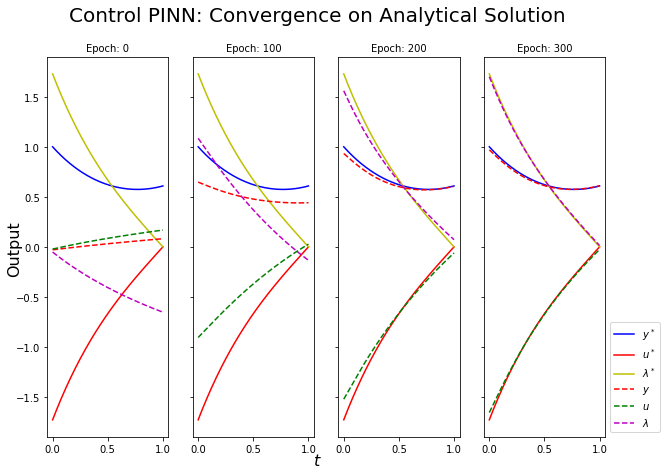

In [14]:
num_subplots = len(prediction_history)
num_rows = 1
num_columns = 4
fig, axs = plt.subplots(num_rows, num_columns, sharex=True, sharey=True, figsize=(10,7))
fig.suptitle('Control PINN: Convergence on Analytical Solution', size=20)
fig.text(0.5, 0.08, '$t$', ha='center',va='center', size=16)
fig.text(0.08, 0.5, 'Output', ha='center',va='center', rotation='vertical', size=16)
index = 0
i = 1
for j in range(num_columns):
  axs[j].set_title('Epoch: {}'.format(epoch_history[index]),fontsize=10)
  axs[j].plot(timespan, y_star, 'b', label=r'$y^*$')
  axs[j].plot(timespan, u_star, 'r', label=r'$u^*$')
  axs[j].plot(timespan, lambda_star, 'y', label=r'$\lambda^*$')
  pred = prediction_history[index]
  axs[j].plot(timespan, pred[:,0], 'r--', label=r'$y$')
  axs[j].plot(timespan, pred[:,1], 'g--', label=r'$u$')
  axs[j].plot(timespan, pred[:,2], 'm--', label=r'$\lambda$')
  index += 1

plt.tight_layout
plt.legend(loc=3,bbox_to_anchor=(1,0))
plt.show()